# Scenarios Score Analysis

In [1]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import matplotlib.pyplot as plt
import pandas as pd

/Users/lauracorssac/Desktop/IDP-lets-go/Analysis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Authorization

Generate a key in the Firebase Console!

In [4]:
cred = credentials.Certificate("/Users/lauracorssac/idp-lets-go-e92b8-firebase-adminsdk-fbsvc-42ad0e1400.json")
firebase_admin.initialize_app(cred)

### Users Fetch

Warning: Don't do it often! This counts as one read per user, so it might get expensive!

In [6]:
db = firestore.client()

users_ref = db.collection("users")
docs = users_ref.stream()

user_data = []
for doc in docs:
    user_data.append(doc.to_dict())

print(user_data)

[{'birthYear': '1998', 'trials': [{'responseTime': 1622, 'step': 2}, {'responseTime': 2208, 'step': 1}, {'responseTime': 1992, 'step': 7}, {'responseTime': 3011, 'step': 3}, {'responseTime': 2644, 'step': 3}, {'responseTime': 1890, 'step': 2}, {'responseTime': 1805, 'step': 5}, {'responseTime': 1673, 'step': 5}, {'responseTime': 4064, 'step': 3}, {'responseTime': 2342, 'step': 1}, {'responseTime': 8363, 'step': 1}, {'responseTime': 1522, 'step': 1}, {'responseTime': 3747, 'step': 2}, {'responseTime': 2923, 'step': 4}, {'responseTime': 1973, 'step': 6}, {'responseTime': 1973, 'step': 4}, {'responseTime': 2142, 'step': 1}, {'responseTime': 2862, 'step': 6}, {'responseTime': 1972, 'step': 3}, {'responseTime': 4565, 'step': 6}, {'responseTime': 1891, 'step': 4}, {'responseTime': 2259, 'step': 2}, {'responseTime': 1870, 'step': 6}, {'responseTime': 5773, 'step': 7}, {'responseTime': 2727, 'step': 6}, {'responseTime': 3695, 'step': 7}, {'responseTime': 2007, 'step': 5}, {'responseTime': 1488

### Score Computation

In [8]:
from pydantic import BaseModel


class Question(BaseModel):
    bias_interrupting: int
    bias_reinforcing: int

questions = [
    
    # 1
    Question(bias_interrupting=1, bias_reinforcing=2),
    
    # 2
    Question(bias_interrupting=2, bias_reinforcing=1),

    # 3
    Question(bias_interrupting=3, bias_reinforcing=0),

    # 4
    Question(bias_interrupting=0, bias_reinforcing=3),

    # 5
    Question(bias_interrupting=2, bias_reinforcing=1),

    # 6
    Question(bias_interrupting=3, bias_reinforcing=2),

    # 7
    Question(bias_interrupting=0, bias_reinforcing=2),

    # 8
    Question(bias_interrupting=3, bias_reinforcing=1),

    # 9
    Question(bias_interrupting=1, bias_reinforcing=3),

    # 10
    Question(bias_interrupting=3, bias_reinforcing=0),

]

In [14]:
for user in user_data:
    answers = user.get("answers")
    user_score = 0
    for answer, question in zip(answers, questions):
        least_index = answer.get("leastIndex")
        most_index = answer.get("mostIndex")
        if most_index == question.bias_interrupting or least_index == question.bias_reinforcing:
            user_score += 1
        if most_index == question.bias_reinforcing or least_index == question.bias_interrupting:
            user_score -= 1

    user["questions_score"] = user_score

questions_scores = [user.get("questions_score") for user in user_data]

questions_scores

[4, 6, 2, 6, 6, 8, -3, 2, -2, 2, 5, 3, 4, 2, 3, 3, 4, 0, -2, 7, -2, -2]

In [15]:
df = pd.DataFrame(user_data)

## Scenarios Score per Group

In [10]:
questions_scores_control = [user.get("questions_score") for user in user_data if user.get("group") == "control"]
questions_scores_target = [user.get("questions_score") for user in user_data if user.get("group") == "target"]

print(questions_scores_control)
print(questions_scores_target)

avg_control = sum(questions_scores_control) / len(questions_scores_control)
avg_target = sum(questions_scores_target) / len(questions_scores_target)

print(avg_control)
print(avg_target)

[6, 8, -3, -2, 5, 3, 3, 4, -2, 7]
[4, 6, 2, 6, 2, 2, 4, 2, 3, 0, -2, -2]
2.9
2.25


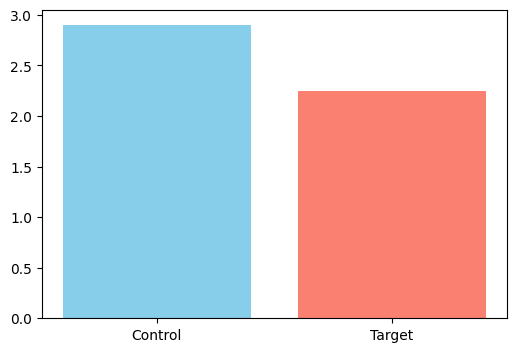

In [11]:
group_names = ['Control', 'Target']
group_averages = [avg_control, avg_target]

plt.figure(figsize=(6, 4))
bars = plt.bar(group_names, group_averages, color=['skyblue', 'salmon'])

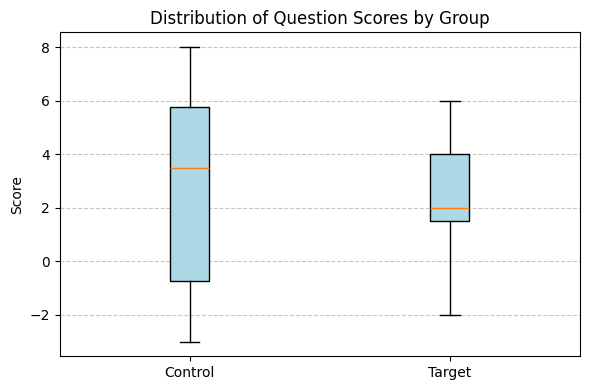

In [12]:
data = [questions_scores_control, questions_scores_target]
group_names = ['Control', 'Target']

plt.figure(figsize=(6, 4))
plt.boxplot(
    data, 
    tick_labels=group_names, 
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
)

plt.title('Distribution of Question Scores by Group')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Scenario Score per Gender

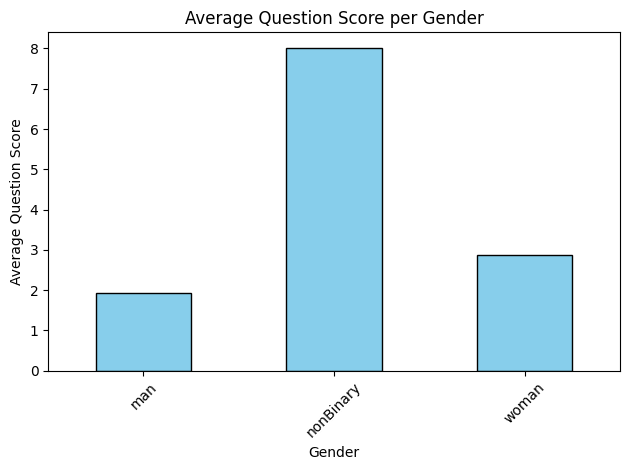

In [16]:
avg_scores = df.groupby('gender')['questions_score'].mean()

# Step 2: Plot as a histogram (bar plot for categorical data)
avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

# Step 3: Add labels and title
plt.xlabel('Gender')
plt.ylabel('Average Question Score')
plt.title('Average Question Score per Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

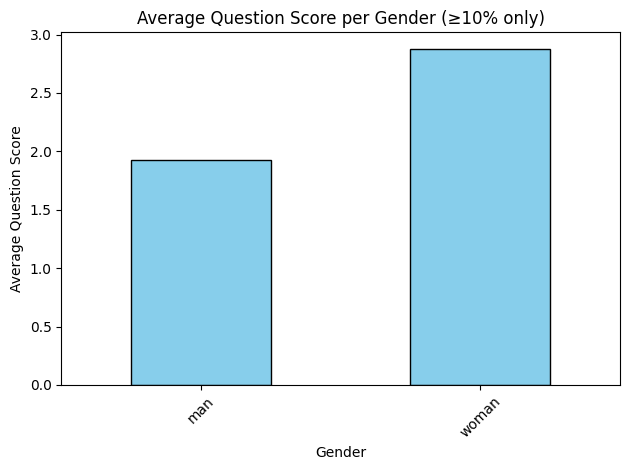

In [17]:
gender_counts = df['gender'].value_counts(normalize=True)

# Step 2: Keep only genders that make up at least 10% of the total
valid_genders = gender_counts[gender_counts >= 0.10].index

# Step 3: Filter the DataFrame
filtered_df = df[df['gender'].isin(valid_genders)]

# Step 4: Group and plot
avg_scores = filtered_df.groupby('gender')['questions_score'].mean()

avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Gender')
plt.ylabel('Average Question Score')
plt.title('Average Question Score per Gender (≥10% only)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Scenario Score per Ethinicity

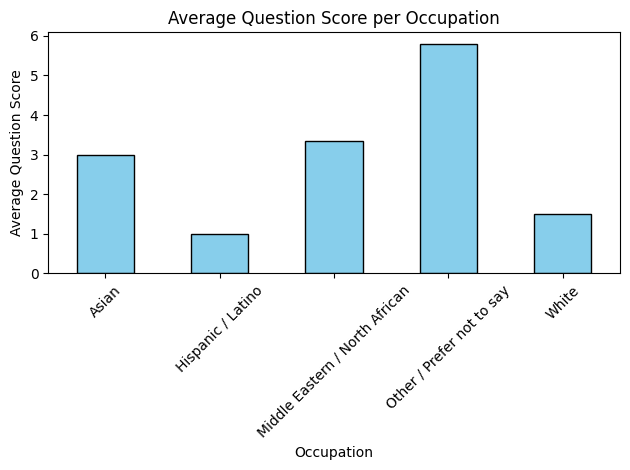

In [23]:
# Expand the occupations list into multiple rows per user
df_exploded = df.explode('races')

# Group and compute average score per occupation
avg_scores = df_exploded.groupby('races')['questions_score'].mean()

avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Occupation')
plt.ylabel('Average Question Score')
plt.title('Average Question Score per Occupation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Scenario Score per Occupation

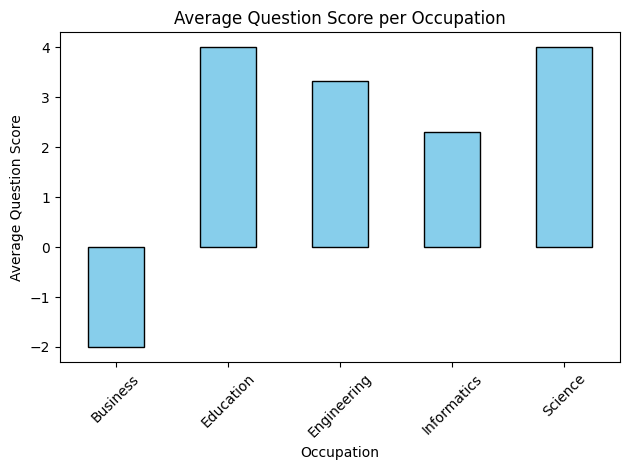

In [29]:
# Expand the occupations list into multiple rows per user
df_exploded = df.explode('professions')

# Group and compute average score per occupation
avg_scores = df_exploded.groupby('professions')['questions_score'].mean()

avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Occupation')
plt.ylabel('Average Question Score')
plt.title('Average Question Score per Occupation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

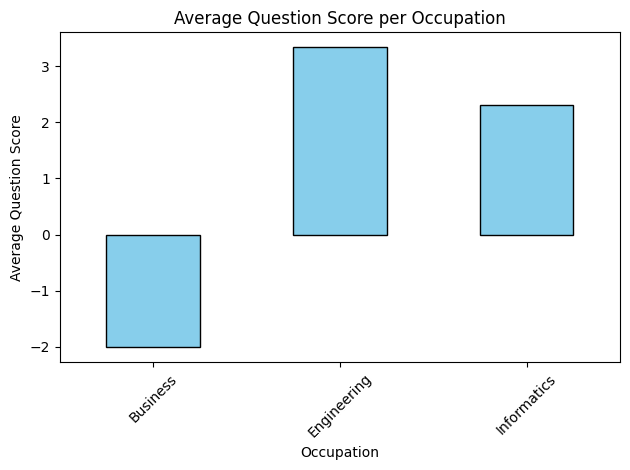

In [30]:
occupation_counts = df_exploded['professions'].value_counts(normalize=True)

valid_occupations = occupation_counts[occupation_counts >= 0.10].index

filtered_df = df_exploded[df_exploded['professions'].isin(valid_occupations)]

avg_scores = filtered_df.groupby('professions')['questions_score'].mean()

avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Occupation')
plt.ylabel('Average Question Score')
plt.title('Average Question Score per Occupation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Scenario Score per Education

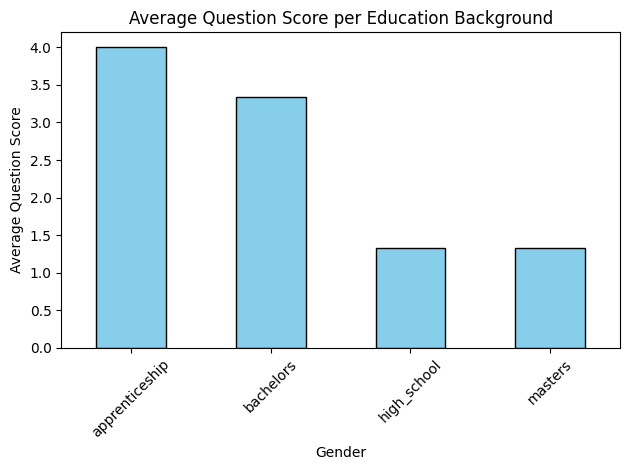

In [31]:
avg_scores = df.groupby('education')['questions_score'].mean()

# Step 2: Plot as a histogram (bar plot for categorical data)
avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

# Step 3: Add labels and title
plt.xlabel('Gender')
plt.ylabel('Average Question Score')
plt.title('Average Question Score per Education Background')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

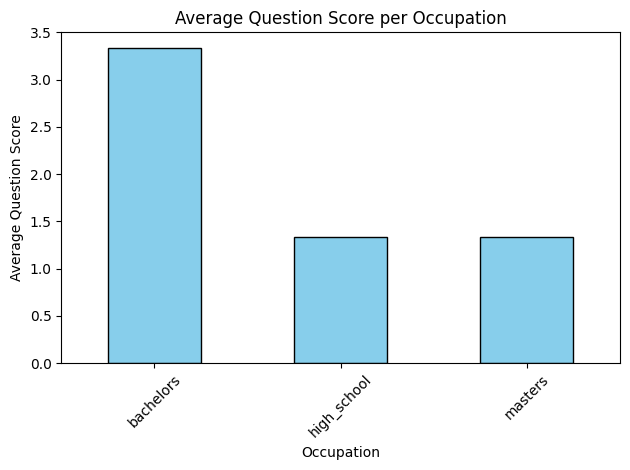

In [32]:
edu_counts = df['education'].value_counts(normalize=True)

valid_edu = edu_counts[edu_counts >= 0.10].index

filtered_df = df[df['education'].isin(valid_edu)]

avg_scores = filtered_df.groupby('education')['questions_score'].mean()

avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Occupation')
plt.ylabel('Average Question Score')
plt.title('Average Question Score per Occupation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scenarios Score per Age

/var/folders/bc/gcpryyxs74146gl1yfg2msyw0000gn/T/ipykernel_23924/2841056154.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_scores = df.groupby('age_group')['questions_score'].mean()


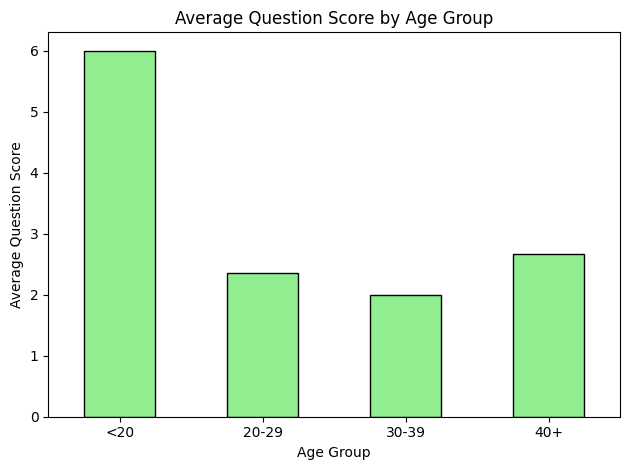

In [33]:
df['age'] = 2025 - df['birthYear'].astype(int)

bins = [0, 19, 29, 39, float('inf')]
labels = ['<20', '20-29', '30-39', '40+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

avg_scores = df.groupby('age_group')['questions_score'].mean()

avg_scores.plot(kind='bar', color='lightgreen', edgecolor='black')

plt.xlabel('Age Group')
plt.ylabel('Average Question Score')
plt.title('Average Question Score by Age Group')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/var/folders/bc/gcpryyxs74146gl1yfg2msyw0000gn/T/ipykernel_23924/2307503565.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_scores = filtered_df.groupby('age_group')['questions_score'].mean()


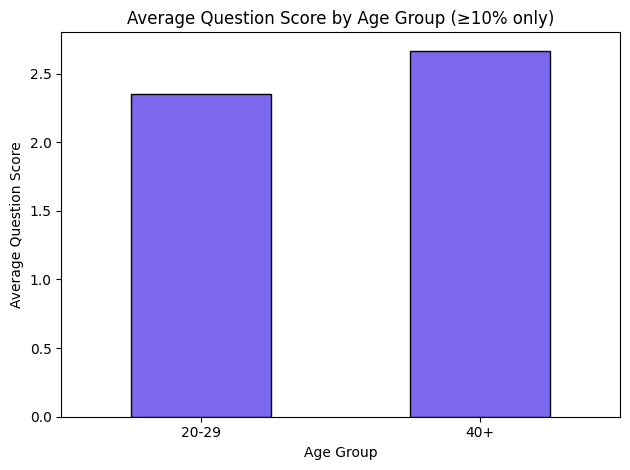

In [34]:
age_group_counts = df['age_group'].value_counts(normalize=True)
valid_age_groups = age_group_counts[age_group_counts >= 0.10].index
filtered_df = df[df['age_group'].isin(valid_age_groups)]

avg_scores = filtered_df.groupby('age_group')['questions_score'].mean()

avg_scores = avg_scores.dropna()

avg_scores.plot(kind='bar', color='mediumslateblue', edgecolor='black')

plt.xlabel('Age Group')
plt.ylabel('Average Question Score')
plt.title('Average Question Score by Age Group (≥10% only)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()